In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
from sklearn.model_selection import cross_val_score
from utils import make_label_column_numeric
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel

In [2]:
csv_path = './data/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

#"Age", "Hours-per-week", 
# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

# Set the column in the dataset you wish for the model to predict
label_column = 'Over-50K'

CLASSES = ['Under-50K', 'Over-50K']

# Make the label column numeric (0 and 1), for use in our model.
# In this case, examples with a target value of '>50K' are considered to be in
# the '1' (positive) class and all other examples are considered to be in the
# '0' (negative) class.
make_label_column_numeric(df, label_column, lambda val: val == '>50K')

In [3]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_columns = list(set(cols) - set(num_cols))

In [4]:
df = pd.get_dummies(df, columns=cat_columns)

In [5]:
df = df.sample(frac=1)# split training and testing data
d_train = df[:25000]
d_test = df[25000:]

X_train = d_train.drop([label_column], axis=1)
y_train = d_train[label_column]

X_test = d_test.drop([label_column], axis=1)
y_test = d_test[label_column]

# d_att = df.drop([label_column], axis=1)
#d_gt50 = df[label_column]

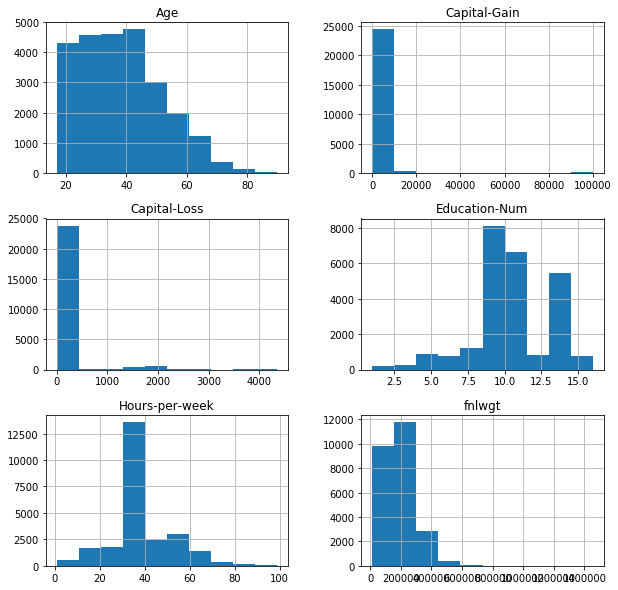

In [6]:
num_attributes = X_train.select_dtypes(include=['int'])
num_attributes.hist(figsize=(10,10))
plt.show()

### What features to use for explanation?

In [14]:
corr_data_target = X_train.corrwith(y_train)

In [15]:
np.unique(X_train.corrwith(y_train) < 0, return_counts=True)

(array([False,  True]), array([49, 59]))

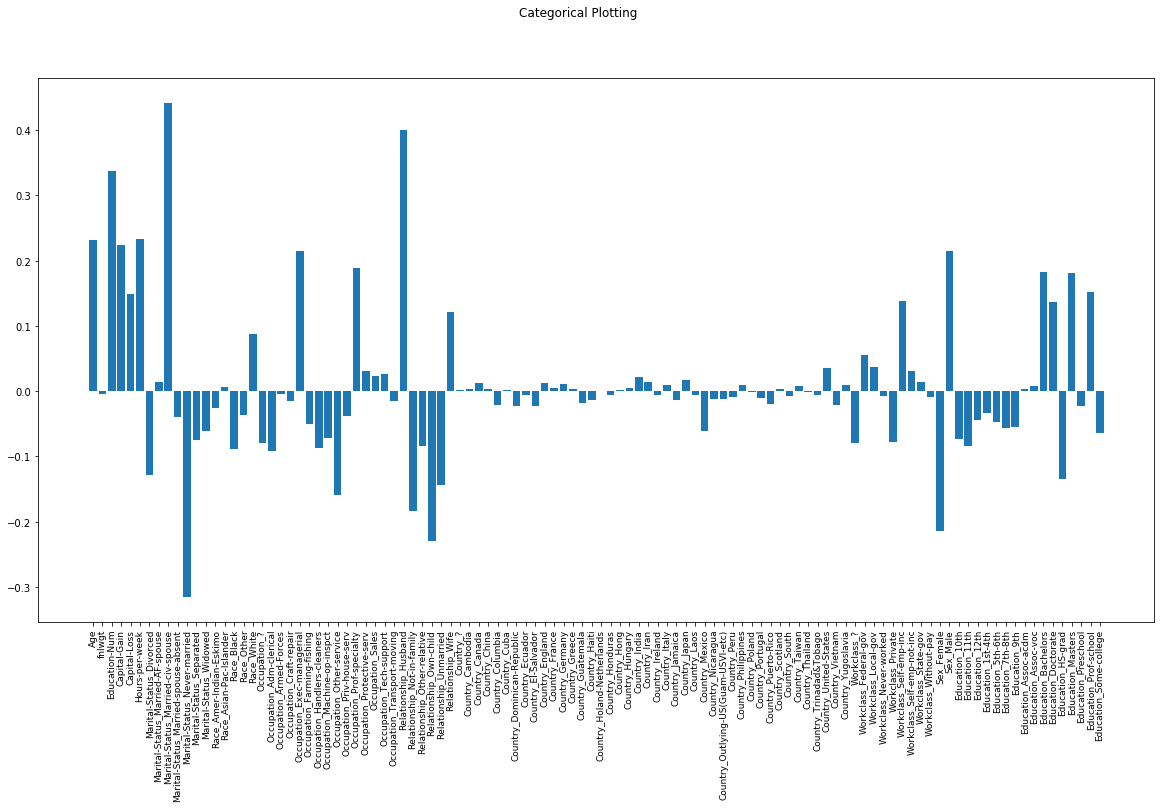

In [37]:
names = list(corr_data_target.index)
values = list(corr_data_target.values)

fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
axs.bar(names, values)
plt.xticks(rotation=90, size=9)
fig.suptitle('Categorical Plotting')
plt.show()

In [28]:
corr_data_target.nlargest()

Marital-Status_Married-civ-spouse    0.441652
Relationship_Husband                 0.399815
Education-Num                        0.337635
Hours-per-week                       0.233070
Age                                  0.230922
dtype: float64

In [29]:
corr_data_target.nsmallest()

Marital-Status_Never-married   -0.315387
Relationship_Own-child         -0.229423
Sex_Female                     -0.214872
Relationship_Not-in-family     -0.182859
Occupation_Other-service       -0.158405
dtype: float64

In [31]:
top_5_correlated_columns = ['Marital-Status_Married-civ-spouse', 'Relationship_Husband', 
                            'Education-Num', 'Marital-Status_Never-married']

# Decision Tree (Max depth = 3)

In [29]:
t = tree.DecisionTreeClassifier(criterion='entropy', 
                                max_depth=3, min_samples_leaf=10, min_samples_split=20)
t = t.fit(X_train, y_train)

In [31]:
predicted_test_decisiontree = t.predict(X_test)

In [32]:
accuracy_score(y_test, predicted_test_decisiontree)

0.8465811400608385

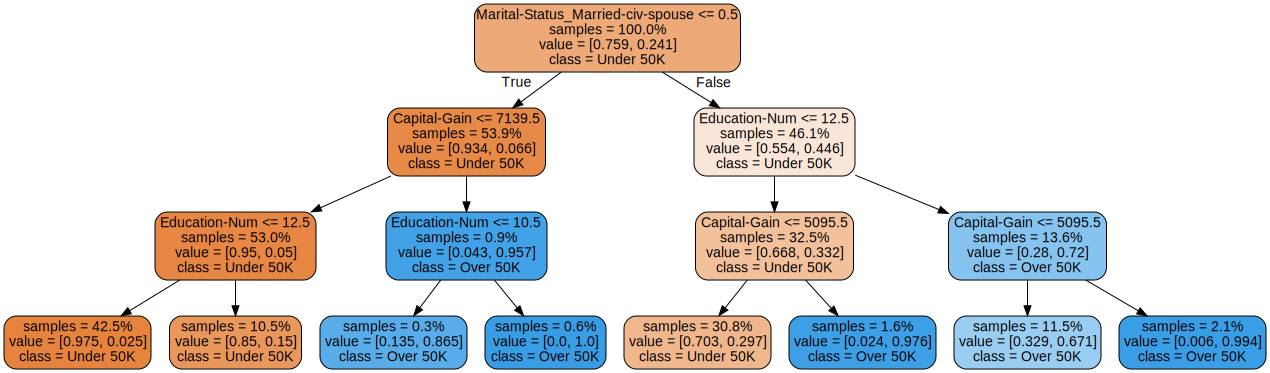

In [34]:
dot_data = tree.export_graphviz(t, out_file=None, label='all', impurity=False, proportion=True, 
                               feature_names=list(X_train), class_names=['Under 50K', 'Over 50K'],
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render(filename='dt_new.dot')
graph

### Linear models

In [46]:
linear = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
linear.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
predicted_test_linear = linear.predict(X_test)
accuracy_score(y_test, predicted_test_linear)

0.7975135564078826

### Linear model

In [66]:
cols_userstudy = ['Age', 'Education-Num', 'Hours-per-week']

for i in cols_userstudy:
    idx = X_train.columns.get_loc(i)
    _coef = linear.coef_[0][idx]
    print('Feature: {}'.format(X_train.columns[idx]))
    print('    (Log odds = Coeff): {}'.format(_coef))

Feature: Age
    (Log odds = Coeff): 7197.552662708517
Feature: Education-Num
    (Log odds = Coeff): 2119.287787546146
Feature: Hours-per-week
    (Log odds = Coeff): 6774.749459139136


### Case study

In [10]:
applicant_id_1 = 18932
applicant_id_2 = 18000

In [11]:
df.iloc[applicant_id_1]

Age                               63
Workclass                    Private
fnlwgt                        266083
Education                    7th-8th
Education-Num                      4
Marital-Status    Married-civ-spouse
Occupation          Transport-moving
Relationship                 Husband
Race                           White
Sex                             Male
Capital-Gain                       0
Capital-Loss                       0
Hours-per-week                    60
Country                United-States
Over-50K                           1
Name: 18932, dtype: object

In [12]:
df.iloc[applicant_id_2]

Age                               26
Workclass                    Private
fnlwgt                        279145
Education                    HS-grad
Education-Num                      9
Marital-Status    Married-civ-spouse
Occupation              Craft-repair
Relationship                 Husband
Race                           White
Sex                             Male
Capital-Gain                       0
Capital-Loss                       0
Hours-per-week                    50
Country                United-States
Over-50K                           0
Name: 18000, dtype: object

# Prediction for applicants

In [56]:
y_train.iloc[applicant_id_1], y_train.iloc[applicant_id_2]

(0, 1)

### Decision Tree

In [73]:
tree_predicted_applicant_1 = t.predict(X_train)[applicant_id_1]
tree_predicted_applicant_1

0

In [50]:
tree_predicted_applicant_2 = t.predict(X_train)[applicant_id_2]
tree_predicted_applicant_2

0

### Linear 

In [373]:
linear_predicted_applicant_1 = linear.predict(X_train)[applicant_id_1]
linear_predicted_applicant_1

0

In [412]:
linear_predicted_applicant_2 = linear.predict(X_train)[applicant_id_2]
linear_predicted_applicant_2

0

### Extract rules

In [70]:
def tree_to_pseudo(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"If ( " + features[node] + " <= " + str(threshold[node]) + " ) THEN")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} ELSE {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            #print(indent,"return " + str(value[node]))
            print(indent, "LABEL IS: " + str(CLASSES[t.classes_[np.argmax(value[node])]]))

    recurse(left, right, threshold, features, 0)

In [71]:
tree_to_pseudo(t, list(X_train.columns))

 If ( Marital-Status_Married-civ-spouse <= 0.5 ) THEN
   If ( Capital-Gain <= 7139.5 ) THEN
     If ( Education-Num <= 12.5 ) THEN
       LABEL IS: Under-50K
     } ELSE {
       LABEL IS: Under-50K
     }
   } ELSE {
     If ( Education-Num <= 10.5 ) THEN
       LABEL IS: Over-50K
     } ELSE {
       LABEL IS: Over-50K
     }
   }
 } ELSE {
   If ( Education-Num <= 12.5 ) THEN
     If ( Capital-Gain <= 5095.5 ) THEN
       LABEL IS: Under-50K
     } ELSE {
       LABEL IS: Over-50K
     }
   } ELSE {
     If ( Capital-Gain <= 5095.5 ) THEN
       LABEL IS: Over-50K
     } ELSE {
       LABEL IS: Over-50K
     }
   }
 }


### Fairness

### Demographic parity

In [104]:
X_train_male = X_train[X_train['Sex_Male'] == 1]
X_train_female = X_train[X_train['Sex_Male'] == 0]

values_male, counts_male = np.unique(linear.predict(X_train_male), return_counts=True)
values_female, counts_female = np.unique(linear.predict(X_train[X_train['Sex_Male'] == 0]), return_counts=True)

In [105]:
counts_male / len(X_train_male)

array([0.92688454, 0.07311546])

In [106]:
counts_female / len(X_train_female)

array([0.96003401, 0.03996599])

### Equality of Opportunity

In [ ]:
%pylab inline
%load_ext memory_profiler
from pomegranate import BayesianNetwork
import seaborn, time
seaborn.set_style('whitegrid')

model = BayesianNetwork.from_samples(X_train, algorithm='exact')
print(model.structure)
model.plot()

Populating the interactive namespace from numpy and matplotlib
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [10]:
!pip install pomegranate

    100% |████████████████████████████████| 5.3MB 4.3MB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 8.1MB/s ta 0:00:011
